In [22]:
'''
Initializes python packages and give paths to appropriate files to be used like categories file,
the twitter file to be used alongwith the default stopword list (This is where our own created stoplist will be declared too).
'''
from __future__ import print_function
from IPython.display import display
import datetime, calendar, nltk, string, math, csv, glob, ntpath, os.path
import numpy as np
from gensim.models import Phrases
from collections import defaultdict
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer; wnl = WordNetLemmatizer()
import warnings, matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
#from rirdc_lib_old import cleanUp, calculate_seed
import pyLDAvis, pyLDAvis.sklearn; pyLDAvis.enable_notebook()
from sklearn.cluster import KMeans
import matplotlib.image as mpimg
from matplotlib import cm
import pandas as pd

path = r'C:\Users\n9553291\Documents\GitHub\RIRDC_project\files required'
stopwords_file, categories_file = path+'\\stopwords.txt', path+'\\Category_DomainTerms.txt' # {(category, term)}
out_fname_cluster = path+'\\cluster_data_file.csv'
extra_cats_file=path+'\\extra_cats.txt'

#Give the wordnet path here
wordnet_path=path+'\\corpora\\wn-domains-3.2\\wn-domains-3.2-20070223'

n_topics, seed_ratio = 5, 0.25
max_df, min_df = 0.5, 0.1 # For the VSM
topic_groups=[]
delimiter=','

def keywithmaxval(d):
    v=list(d.values());k=list(d.keys())
    return k[v.index(max(v))]

value=int(input("1 for twitter and 2 for patents"))
if value==1:
    data_file=path+'\\results-20170725-145833.csv'
elif value==2:
    data_file=path+'\\Computer Vision_out.txt'
    delimiter='\t'
print('Loading packages and file paths declarations done...')

1 for twitter and 2 for patents2
Loading packages and file paths declarations done...


In [24]:
#Creates a new file from the tweet file by getting rid of rows that are incomplete by appending their content to the 
#preceding row and deleting blank rows
test_file=open(data_file,encoding="ISO-8859-1")
twitter_file = open(out_fname_cluster, 'w',encoding="ISO-8859-1",newline='')
reader = csv.reader(test_file, delimiter=delimiter)
writer = csv.writer(twitter_file)
next(reader,None)
prev=reader
for row in reader:
    if row[0] in (None, ""):
        continue
    for term in row[3]:
        if term.isalpha()==False or ord(term) > 127:
            row[3]=row[3].replace(term,' ')
        wnl.lemmatize(term,'n')
    writer.writerow(row)
test_file.close()
twitter_file.close()
print('Done Creating the cleaned version of tweet file...')

Done Creating the cleaned version of tweet file...


In [25]:
# Loading the Wordnet domains.
s2d = []
for i in open(wordnet_path, 'r'):
    ssid, doms = i.strip().split('\t')
    doms = doms.split()
    for d in doms:
        s2d.append(d)
synset2domains=list(set(s2d))
extra_cats={}

for syn in synset2domains:
    try:
        p_list,c_list,categories=[],[],[]
        obj=wn.synset(syn+'.n.01')
        topics=obj.topic_domains()
        parents=obj.hypernyms()
        children=obj.hyponyms()
        domains= [ topic.lemma_names() for topic in topics ] 
        for sublist in domains:
            for item in sublist:
                    categories.append(str(item.replace('_',' ')))
        pwords = [ parent.lemma_names() for parent in parents ]
        for sublist in pwords:
            for item in sublist:
                    p_list.append(str(item.replace('_',' ')))
        cwords = [ child.lemma_names() for child in children]
        for sublist in cwords:
            for item in sublist:
                    c_list.append(str(item.replace('_',' ')))
        words=p_list+c_list
        if categories:
            for category in categories:
                extra_cats[category]=words
    except:
        pass

out_extra_cats = open(extra_cats_file, 'w')
for k in extra_cats.keys():
    for v in extra_cats[k]:
        out_extra_cats.write(k+", ")
        out_extra_cats.write(v+"\n")
out_extra_cats.close()
print("Done creating extra categories..")

Done creating extra categories..


In [26]:
#Creates the equal number of files for the unique months and locations present 
#in the data file and dumps corresponding tweets to the appropriate ones.

input_file = open(out_fname_cluster,encoding="ISO-8859-1")
date_list,country_list=[],[]
reader = csv.reader(input_file, delimiter=',')

#Creates a unique list of months and countries from tweets
for row in reader:
    created_at,*rest=row[1].split(' ')           #splits the 'Created at' column to retrieve 'month'
    year,months,date=created_at.split('-')
    month=calendar.month_name[int(months)]
    if month not in date_list:
        date_list.append(str(month))
    if row[6] not in country_list:
        country_list.append(str(row[6]))

#Creates csv files with names after months
for month in date_list:
    outfile = open(path+'\Data{0:2s}'.format(str(month))+'.csv', 'w', newline='',encoding="ISO-8859-1")
    writer = csv.writer(outfile, delimiter = ',')
    writer.writerow(["tweet_id","month","text","country"])
    outfile.close()

#Creates csv files with names after countries
for country in country_list:
   outfile = open(path+'\Data{0:2s}'.format(str(country))+'.csv', 'w', newline='',encoding="ISO-8859-1")
   writer = csv.writer(outfile, delimiter = ',')
   writer.writerow(["tweet_id","month","text","country"])
   outfile.close()

#Shifts rows of tweets to their respective csv files  -->  For Months
for month1 in date_list:
  with open(out_fname_cluster, 'r',encoding="ISO-8859-1") as f:
    reader = csv.reader(f, delimiter=',')
    outfile = open(path+'\Data{0:2s}'.format(str(month1))+'.csv','a', newline='',encoding="ISO-8859-1")
    for row in reader:
        if row[0] in (None, ""):
          continue
        created_at,*rest=row[1].split(' ')  
        year,months,date=created_at.split('-')
        month2=calendar.month_name[int(months)]
        if month1==month2:
            writer = csv.writer(outfile, delimiter =',')
            writer.writerow(row)
    outfile.close()

#Shifts rows of tweets to their respective csv files  -->  For Countries
for country1 in country_list:
  with open(out_fname_cluster, 'r',encoding="ISO-8859-1") as f:
    reader = csv.reader(f, delimiter=',')
    outfile = open(path+'\Data{0:2s}'.format(str(country1))+'.csv','a', newline='',encoding="ISO-8859-1")
    for row in reader:
        if row[0] in (None, ""):
          continue
        country2=str(row[6])
        if country1==country2:
            writer = csv.writer(outfile, delimiter =',')
            writer.writerow(row)
    outfile.close()

print('Done moving tweets to their respective months and location files...')

Done moving tweets to their respective months and location files...


In [27]:
#Tokenizes and remove stopwords from the tweet column of the data file for bigrams and unigrams --> For Months

df=open(stopwords_file,"r",encoding="ISO-8859-1", errors='replace')
stops=df.readlines(); df.close()
stops = set([word.strip() for word in stops])                  #stores stopwords tokens from the stoplist in a list
stops1=list(stops)
stops2=''.join(stops1)
tweet_id_m, text_m={},{}
tweet_id_c,text_c={},{}
docs,r=[],[]
sentences=[]
DocZ_m, DocZ_c, DocZ_m_wob, DocZ_c_wob = {},{},{},{} # will be used to find categories
for month in date_list:
    u,p,d,d_wob=[],[],[],[]
    outfile = open(path+'\Data{0:2s}'.format(str(month))+'.csv', 'r', newline='',encoding="ISO-8859-1")
    reader = csv.reader(outfile, delimiter=',')
    next(reader,None)
    docs=list(reader);
    for doc in docs:    
        tmp = [t.strip() for t in doc]
        try:
            if len(tmp[3])>0: # Making sure not blanks
                sentence = [word
                    for word in nltk.word_tokenize(tmp[3].lower())
                    if word not in string.punctuation
                           and len(word)>3
                           ]
                filtered_word_list = sentence[:] #make a copy of the word_list
                for term in sentence: # iterate over word_list
                    if term in stops2: 
                        filtered_word_list.remove(term)
                d_wob.append(tmp[3].lower())                  #Unigrams List
                sentences.append(filtered_word_list)                  #Bigrams List
                filtered=' '.join(filtered_word_list)
                u.append(tmp[0]); p.append(tmp[3]);d.append(filtered)
        except:
            pass
    tweet_id_m[month]=u
    text_m[month]=p 
    DocZ_m[month]=d
    DocZ_m_wob[month]=d_wob
   
print("For the months found")
print("The bigrams are -->", DocZ_m)
#print("The unigrams are -->", DocZ_m_wob)

#Gets the top five bigrams
flat_list = [item for sublist in sentences for item in sublist]
word_counter = {}
for word in flat_list:
     if word in word_counter:
        word_counter[word] += 1
     else:
         word_counter[word] = 1
popular_words = sorted(word_counter, key = word_counter.get, reverse = True)
top_5 = popular_words[:5]
print("The top five bigrams are",top_5)
del u,p,d,d_wob,sentence
    
del docs
print("Clean-up for months done...,", end = ' ', flush = True)  

For the months found
The bigrams are --> {'June': ['apparatus methods described image blood vessel subject including computer processor determining presence device portion blood vessel image computer processor determines classification device given type device based classification device given type device designates parameter calculated computer processor automatically calculates designated parameter generates output output device response calculated parameter applications described', 'computer implemented method automatically identifying shot changes video sequence real near real disclosed optical flow energy change differences frames square differences optical flow compensated frames histogram changes frames analyzed stored frame buffers feature vector formed combination measurements compared feature vector formed thresholds based tunable recall precision declare presence absence shot change', 'computer vision image processing method removing blond hair color pixels digital image ski

In [41]:
#transforming the corpus into vector space using tf-idf

tfidf_vectorizer,tfidf_matrix,terms={},{},{}
for m in date_list:
    tfidf_vectorizer[m] = TfidfVectorizer(max_df=1.0, max_features=200000,
                                 min_df=9,stop_words='english', ngram_range=(1,3))
    tfidf_matrix[m] = tfidf_vectorizer[m].fit_transform(DocZ_m[m]) #fit the vectorizer to tweets
    terms[m] = tfidf_vectorizer[m].get_feature_names()
print(terms)
print("VSM done...")

{'June': ['access', 'accordance', 'account', 'acquire', 'acquired', 'acquiring', 'action', 'additional', 'adjacent', 'algorithm', 'algorithms', 'allows', 'analysis', 'analyzed', 'analyzing', 'angle', 'apparatus', 'apparatus comprises', 'apparatus includes', 'apparatus including', 'apparatus method', 'appearance', 'appears', 'appears public', 'appears public collection', 'application', 'applications', 'applied', 'applying', 'area', 'arranged', 'array', 'aspect', 'aspects', 'associated', 'attributes', 'audio', 'augmented', 'augmented reality', 'automated', 'automatic', 'automatically', 'autonomous', 'available', 'axis', 'background', 'based', 'based comparison', 'based image', 'based plurality', 'basis', 'behavior', 'best', 'block', 'blocks', 'build', 'calculate', 'calculated', 'calculating', 'calibration', 'camera', 'cameras', 'candidate', 'capable', 'capture', 'captured', 'captured image', 'captures', 'capturing', 'case', 'certain', 'change', 'changes', 'characteristic', 'characteristi

In [42]:
#clustering the documents using the k-means algorithm

clusters={}
num_clusters = 5        #specify the number of clusters here
km = KMeans(n_clusters=num_clusters,random_state=4000)
for m in date_list:
    km.fit(tfidf_matrix[m])
    clusters[m] = km.labels_.tolist()
print("Clustering done..")

Clustering done..


In [43]:
#creates a dictionary for cluster-docs pair

tweets,frame,mydict={},{},{}
for m in date_list:
    tweets[m] = { 'tweets': DocZ_m[m], 'cluster': clusters[m] }
    frame[m] = pd.DataFrame(tweets[m], index=None,columns = ['tweets', 'cluster'])
    #frame['cluster'].value_counts()
    mydict[m]={k: list(v) for k,v in frame[m].groupby("cluster")["tweets"]}
print(mydict)

{'June': {0: ['method apparatus processing compressing dimensional digital signal constructing sparse representation takes advantage signal geometrical regularity invention comprises warped wavelet packet transform performs cascade warped subband filtering warping grids sampling points adapted signal geometry comprises bandeletisation decorrelates warped wavelet packet coefficients produce sparse representation inverse warped wavelet packet transform inverse bandeletisation reconstruct signal bandelet representation invention comprises compression system quantizes codes bandelet representation decompression system restoration system enhances signal filtering bandelet representation feature vector extraction system pattern recognition applications bandelet representation', 'device method sampling resolution depth data described particular range disparity stereo content comprising following successive steps scaling resolution depth data desired resolution nearest neighbour interpolation 

In [44]:
# Loading categories into category dictionary of set of terms for bigrams and unigrams 

print("Please wait (it's going to take a while): Loading Data,", end = ' ', flush = True)
df=open(categories_file,"r",encoding="ISO-8859-1", errors='replace')
cats=df.readlines(); df.close(); categories = {}


for cat in cats:
     key = cat.split(', ')[0].strip(); term = cat.split(', ')[1].strip().lower()
     try:        
          categories[key].add(term)
     except:
          categories[key] = set([term])               #stores categories-terms as a key-value in a dictionary from the file
del cats,df
df=open(extra_cats_file,"r",encoding="ISO-8859-1", errors='replace')
cats=df.readlines(); df.close(); 
for cat in cats:
     key = cat.split(', ')[0].strip(); term = cat.split(', ')[1].strip().lower()
     try:        
          categories[key].add(term)
     except:
          categories[key] = set([term])               #stores categories-terms as a key-value in a dictionary from the file
del cats,df

print("pre-Categories mapping ... ", flush = True)    
doc_cats_m,doc_cat_m = {}, {}; 
doc_cats_m_wob,doc_cat_m_wob={},{};
for month in date_list:
  doc_cats_m[month],doc_cat_m[month]={},{} 
  for cluster_id in range(0,num_clusters):
     doc_cats_m[month][cluster_id],doc_cat_m[month][cluster_id]={},{}
     for idx,doc in enumerate(mydict[month][cluster_id]):
        notInCategories,total=[],0
        doc_cats_m[month][cluster_id][idx]={}
        for cat, terms in categories.items():
            for term in terms:
                n = doc.count(term)              #calculates the frequency of occurance of terms corresponding to terms for the category
                total+=n
                try:
                    doc_cats_m[month][cluster_id][idx][cat] += n
                except:
                    doc_cats_m[month][cluster_id][idx][cat]= n
        for cat, terms in categories.items():
            if total==0:
                doc_cat_m[month][cluster_id][idx] = None
                doc_cats_m[month][cluster_id][idx][cat] = 0.0
                if month not in notInCategories:
                    notInCategories.append(month)
            else:
                doc_cat_m[month][cluster_id][idx] = keywithmaxval(doc_cats_m[month][cluster_id][idx])           # category of doc[idx]
                doc_cats_m[month][cluster_id][idx][cat] = doc_cats_m[month][cluster_id][idx][cat]/total          # Normalizing to category's ratio
                
del doc
print(doc_cat_m)
print('%d/%d Documents were not in any of the categories.' %(len(notInCategories), len(mydict)), flush = True)

Please wait (it's going to take a while): Loading Data, pre-Categories mapping ... 
{'June': {0: {0: 'mining', 1: 'mining', 2: 'mining', 3: 'computer', 4: 'mining', 5: 'mining', 6: 'computer', 7: 'mining', 8: 'computer', 9: 'mining', 10: None, 11: 'computer', 12: 'computer', 13: 'computer', 14: None, 15: 'computer', 16: 'mining', 17: 'mining', 18: 'computer', 19: 'finance', 20: 'finance', 21: 'mining', 22: None, 23: 'computer', 24: 'computer', 25: 'computer', 26: 'mining', 27: 'computer', 28: 'computer', 29: 'mining', 30: 'mining', 31: 'mining', 32: 'mining', 33: 'computer', 34: 'mining', 35: 'computer', 36: 'computer', 37: 'mining', 38: 'computer', 39: 'computer', 40: 'computer', 41: 'mining', 42: 'mining', 43: 'computer', 44: 'finance', 45: 'computer', 46: 'mining', 47: 'finance', 48: None, 49: 'finance', 50: 'computer', 51: 'mining', 52: 'finance', 53: 'computer', 54: None, 55: 'computer', 56: 'mining', 57: 'computer', 58: 'mining', 59: 'computer', 60: 'computer', 61: None, 62: 'min

In [45]:
#Calculates a score for each domain for each document
topic_categories_freq, topic_categories_score = {}, {}
for month in date_list:
 topic_categories_freq[month],topic_categories_score[month]={},{}
 for cluster_id in range(0,num_clusters):
#topics_groups = [[1,12],[2,18],[3,7,9,14,15,19],[4],[5],[6,8,11],[10,13,16,17],[20]] # Change this depending on the visualization result; PS: this is "LDAtopic+1"
#topics_scores, seeds, seeds_score, clusters, centroids, mse = {}, {}, {}, {}, {}, {}
      topic_categories_freq[month][cluster_id], topic_categories_score[month][cluster_id] = {}, {}
      temp=[]  
      for k,v in doc_cat_m[month][cluster_id].items():
        C=doc_cat_m[month][cluster_id][k]
        temp.append(doc_cat_m[month][cluster_id][k])
        if C: #not None
            try:
                topic_categories_freq[month][cluster_id][C]+=1
                topic_categories_score[month][cluster_id][C]+=doc_cats_m[month][cluster_id][k][C]
            except:
                topic_categories_freq[month][cluster_id][C]=1
                topic_categories_score[month][cluster_id][C]=doc_cats_m[month][cluster_id][k][C]
        else:
            try:
                topic_categories_freq[month][cluster_id]['None']+=1
            except:
                topic_categories_freq[month][cluster_id]['None']=1  
      for k,v in categories.items():
        if k not in temp:
            topic_categories_freq[month][cluster_id][k]=0.0
            topic_categories_score[month][cluster_id][k]=0.0
    # Normalizing scores
      for C in topic_categories_freq[month][cluster_id].keys():
        if C is not 'None':
            N = topic_categories_freq[month][cluster_id][C]
            if N !=0:
                topic_categories_score[month][cluster_id][C] = topic_categories_score[month][cluster_id][C]/N
            else:
                topic_categories_score[month][cluster_id][C] = 0.0
      if topic_categories_freq[month][cluster_id]['agriculture'] == topic_categories_freq[month][cluster_id]['finance'] == topic_categories_freq[month][cluster_id]['mining'] == 0.0:
        topic_categories_freq[month][cluster_id]['None']=1 
      if topic_categories_score[month][cluster_id]['agriculture'] == topic_categories_score[month][cluster_id]['finance'] == topic_categories_score[month][cluster_id]['mining'] == 0.0:
        topic_categories_score[month][cluster_id]['None']=1 
print(topic_categories_freq)
print(topic_categories_score)
print ('Done assigning scores...')
    # doc_cats[idx][cat] ; 
    #seeds[str(topic)], seeds_score[str(topic)] = calculate_seed(dtm_tf,doc_topic,tf_terms,topic,categories,seed_ratio) # return Dictionary [categories]:{docs} ==> nested dict
    #clusters[str(topic)], centroids[str(topic)], mse[str(topic)] = ss_clustering(vsm_topics,seeds[str(topic)],doc_topic,topic) # k from len(seeds[str(topic)])

{'June': {0: {'industry': 0.0, 'military': 0.0, 'dramatic art': 3, 'data processor': 0.0, 'commercial enterprise': 0.0, 'theatre': 0.0, 'None': 25, 'art': 0.0, 'meteorology': 0.0, 'military machine': 0.0, 'business enterprise': 0.0, 'manufacture': 0.0, 'maths': 0.0, 'dramatics': 0.0, 'drama': 0.0, 'science': 0.0, 'theater': 0.0, 'agriculture': 1, 'mining': 123, 'computer': 98, 'mathematics': 0.0, 'war machine': 0.0, 'computing device': 0.0, 'scientific discipline': 0.0, 'electronic computer': 0.0, 'armed forces': 0.0, 'math': 0.0, 'finance': 24, 'information processing system': 0.0, 'architecture': 1, 'business': 0.0, 'artistic creation': 0.0, 'dramaturgy': 0.0, 'armed services': 0.0, 'artistic production': 0.0, 'computing machine': 0.0, 'linguistics': 0.0}, 1: {'industry': 0.0, 'military': 2, 'dramatic art': 4, 'data processor': 0.0, 'commercial enterprise': 1, 'theatre': 0.0, 'None': 16, 'dramatics': 0.0, 'business': 0.0, 'art': 0.0, 'meteorology': 0.0, 'military machine': 0.0, 'arch

In [46]:

words_dict,words,termss={},{},{}
for month in date_list:
    tfidf_vectorizer[month] = TfidfVectorizer(max_df=1.0, max_features=200000,
                                 min_df=9,stop_words='english', ngram_range=(1,3))
    termss[month] = {}
    words_dict[month],words[month]={},{}
    for cluster_id in range(0,num_clusters):
        tfidf_matrix[month] = tfidf_vectorizer[month].fit_transform(mydict[month][cluster_id])
        km.fit(tfidf_matrix[month])
        order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
        vocab_frame = pd.DataFrame({'words': mydict[month][cluster_id]}, index = mydict[month][cluster_id])
        #print("Before",vocab_frame)
        vocab_frame.dropna(axis=0, how='any')
        #print("After",vocab_frame)
        words_dict[month][cluster_id]={}
        words[month][cluster_id]={}
        termss[month][cluster_id]=tfidf_vectorizer[month].get_feature_names()
        #sort cluster centers by proximity to centroid
        for ind in order_centroids[cluster_id, :6]: #replace 6 with n words per cluster
            words[month][cluster_id]=str(vocab_frame.ix[termss[month][cluster_id][ind].split(' ')].values.tolist()[0][0]).encode('ascii', 'ignore').decode()
        if cluster_id not in words_dict[month]:
            words_dict[month][cluster_id]=[]
        #print(words)
    for idx in range(0,num_clusters):
        word=words[month][idx]
        if word in words_dict[month][idx] or word=='nan':
                continue
        else:
                words_dict[month][idx]=word
print(words_dict)

{'June': {0: {}, 1: {}, 2: {}, 3: {}, 4: {}}, 'July': {0: {}, 1: {}, 2: {}, 3: {}, 4: {}}, 'January': {0: {}, 1: {}, 2: {}, 3: {}, 4: {}}, 'August': {0: {}, 1: {}, 2: {}, 3: {}, 4: {}}, 'March': {0: {}, 1: {}, 2: {}, 3: {}, 4: {}}, 'May': {0: {}, 1: {}, 2: {}, 3: {}, 4: {}}, 'September': {0: {}, 1: {}, 2: {}, 3: {}, 4: {}}, 'April': {0: {}, 1: {}, 2: {}, 3: {}, 4: {}}, 'February': {0: {}, 1: {}, 2: {}, 3: {}, 4: {}}}


For month January
For Cluster ID 0
Visualization based on Category frequency: 


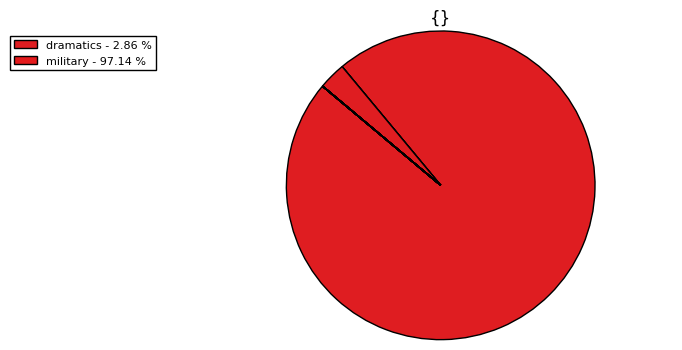

For Cluster ID 1
Visualization based on Category frequency: 


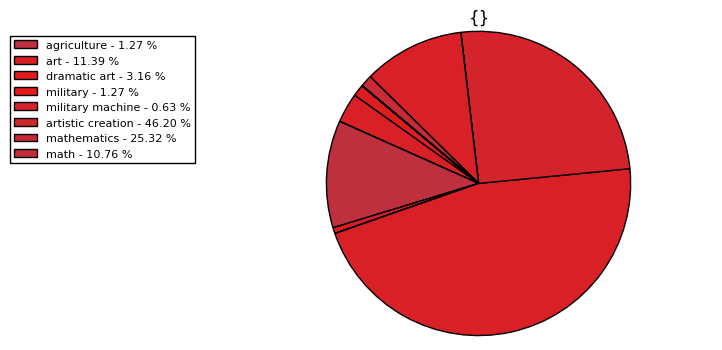

For Cluster ID 2
Visualization based on Category frequency: 


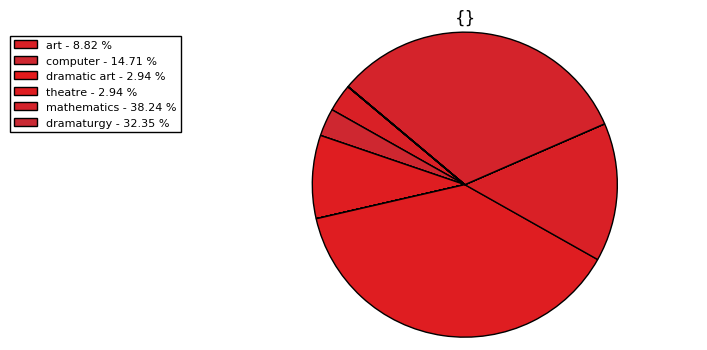

For Cluster ID 3
Visualization based on Category frequency: 


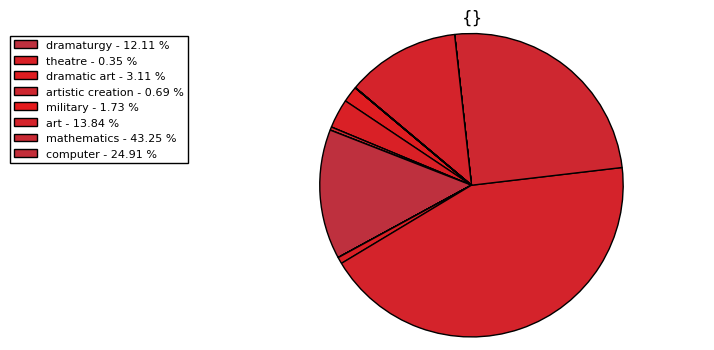

For Cluster ID 4
Visualization based on Category frequency: 


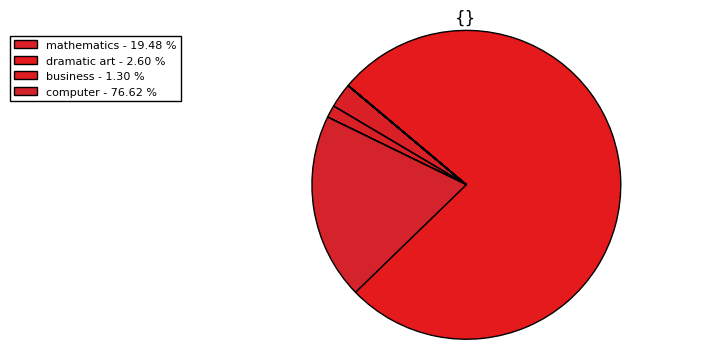

For month February
For Cluster ID 0
Visualization based on Category frequency: 


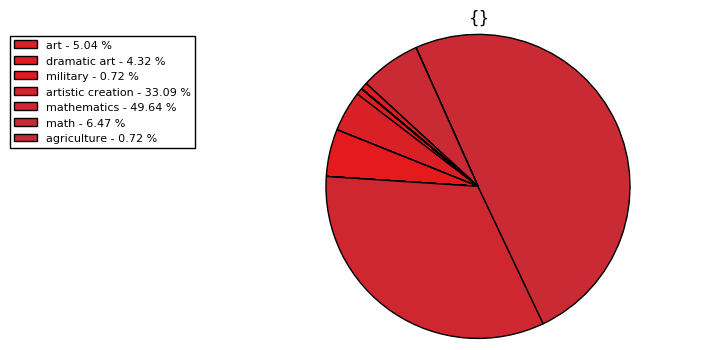

For Cluster ID 1
Visualization based on Category frequency: 


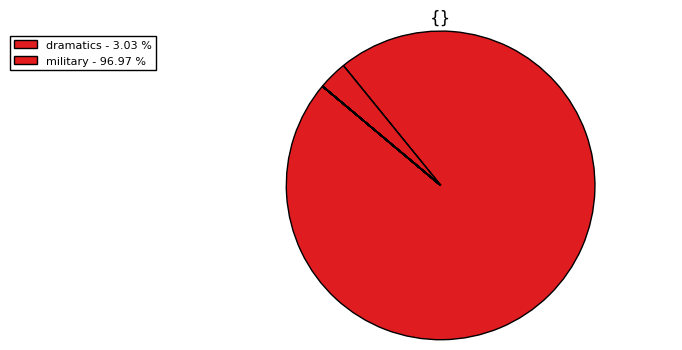

For Cluster ID 2
Visualization based on Category frequency: 


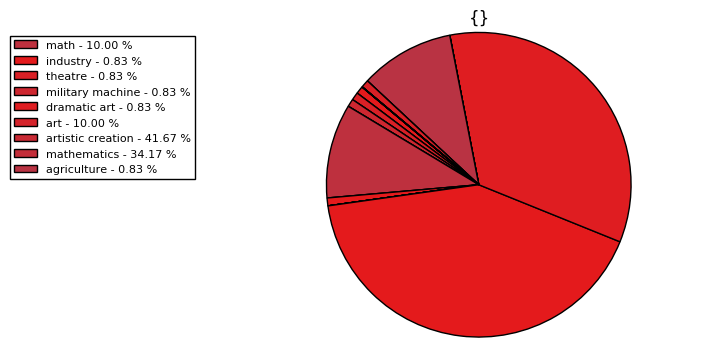

For Cluster ID 3
Visualization based on Category frequency: 


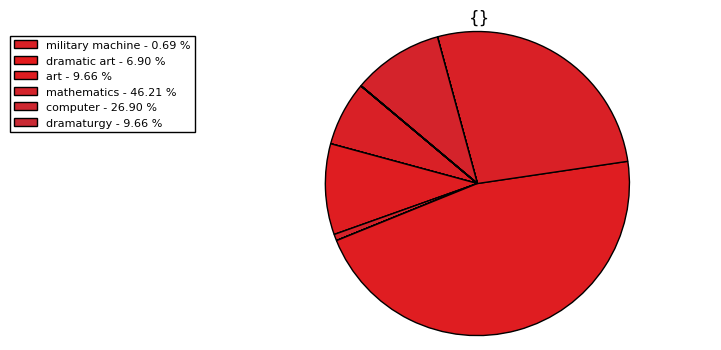

For Cluster ID 4
Visualization based on Category frequency: 


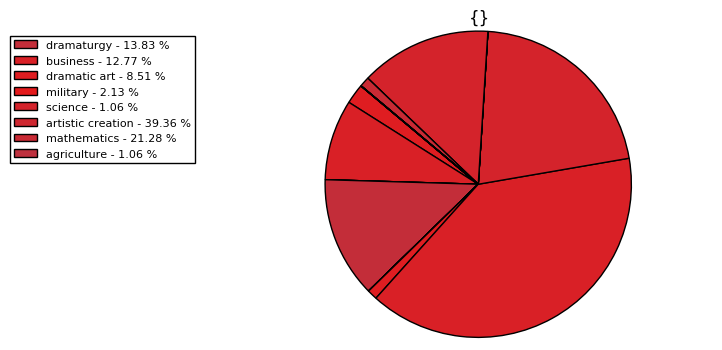

For month March
For Cluster ID 0
Visualization based on Category frequency: 


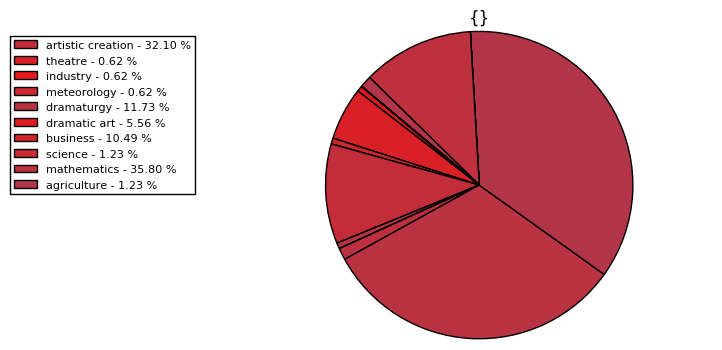

For Cluster ID 1
Visualization based on Category frequency: 


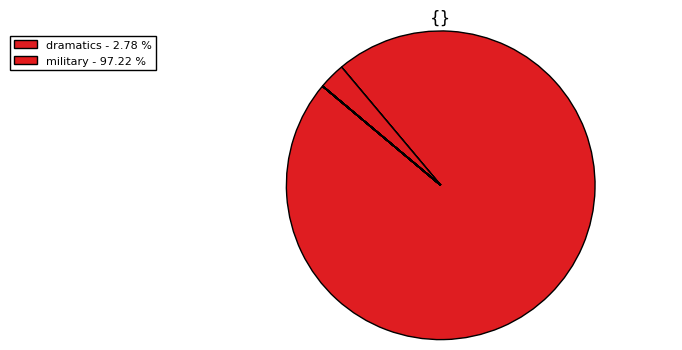

For Cluster ID 2
Visualization based on Category frequency: 


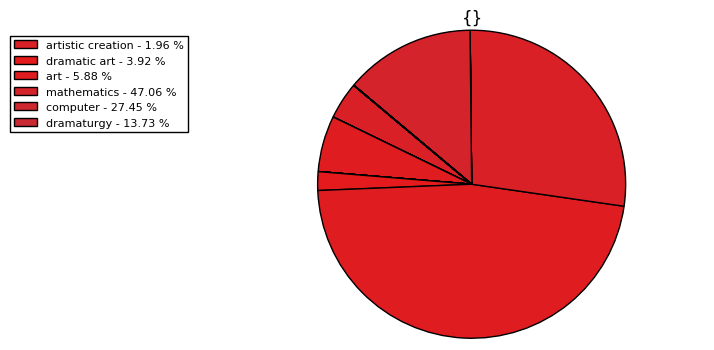

For Cluster ID 3
Visualization based on Category frequency: 


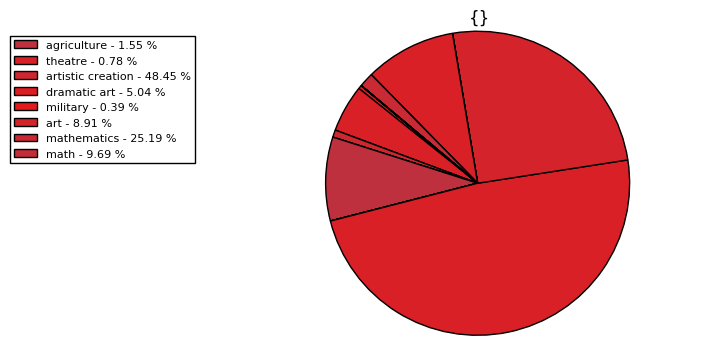

For Cluster ID 4
Visualization based on Category frequency: 


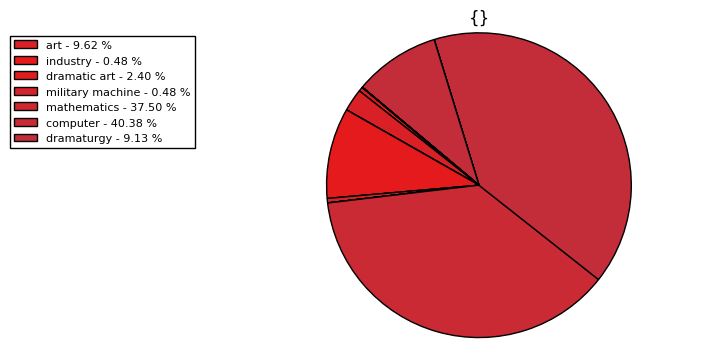

For month April
For Cluster ID 0
Visualization based on Category frequency: 


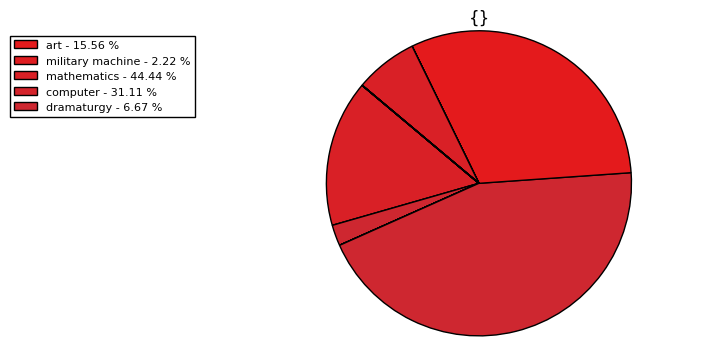

For Cluster ID 1
Visualization based on Category frequency: 


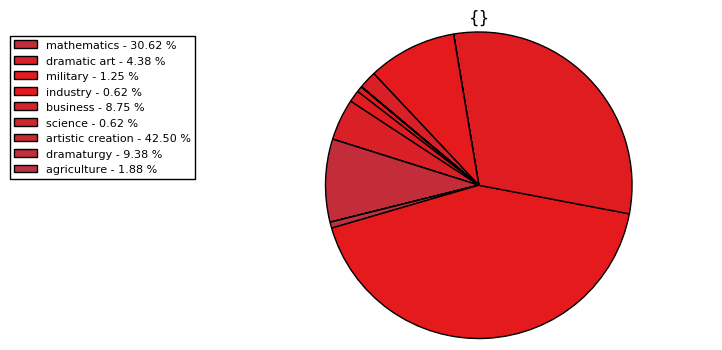

For Cluster ID 2
Visualization based on Category frequency: 


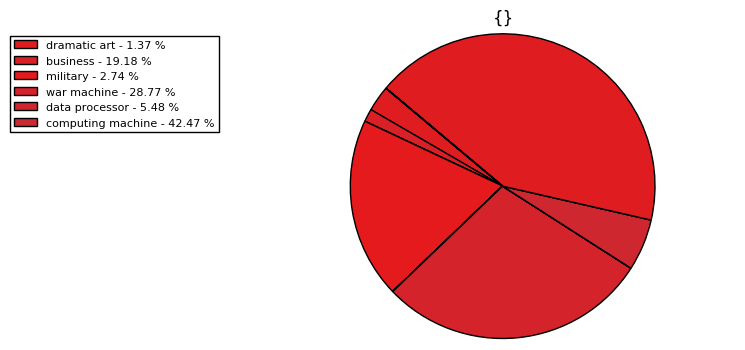

For Cluster ID 3
Visualization based on Category frequency: 


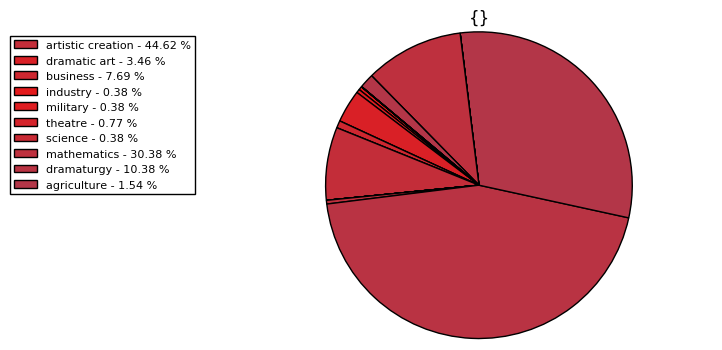

For Cluster ID 4
Visualization based on Category frequency: 


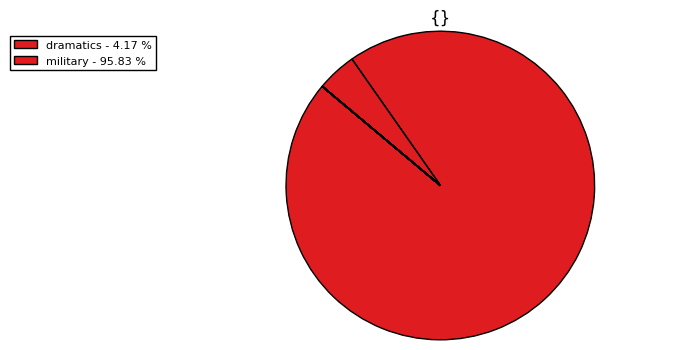

For month May
For Cluster ID 0
Visualization based on Category frequency: 


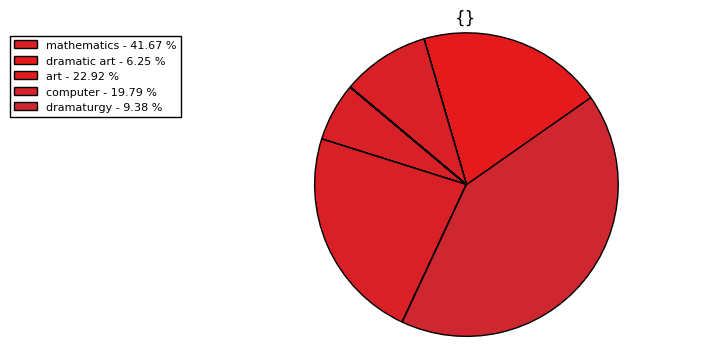

For Cluster ID 1
Visualization based on Category frequency: 


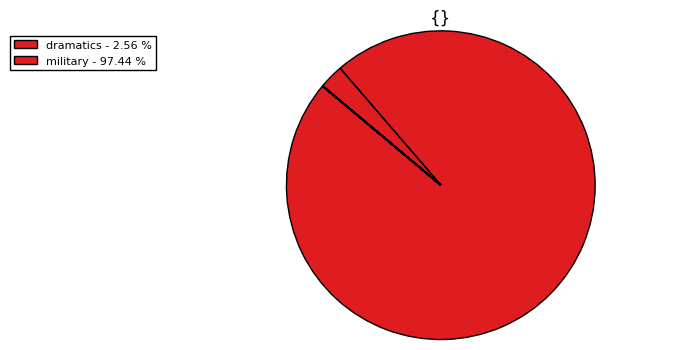

For Cluster ID 2
Visualization based on Category frequency: 


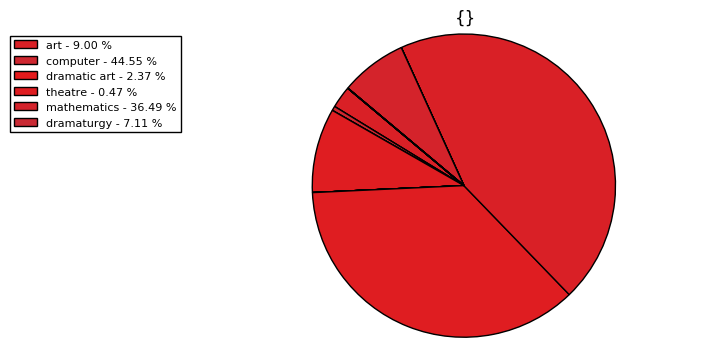

For Cluster ID 3
Visualization based on Category frequency: 


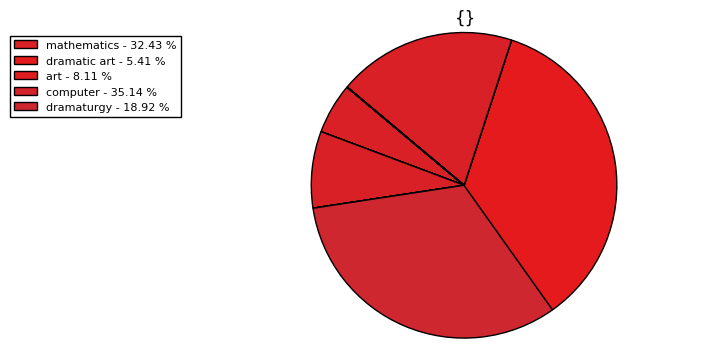

For Cluster ID 4
Visualization based on Category frequency: 


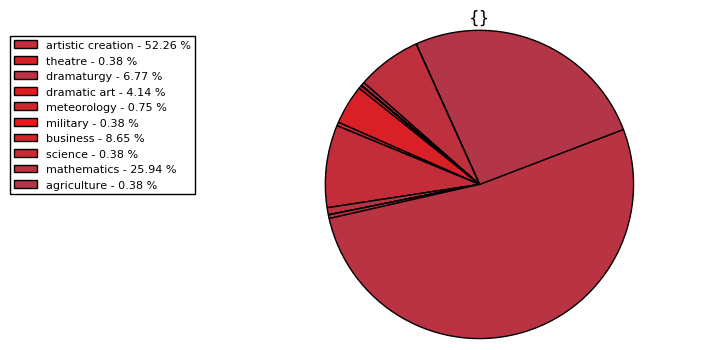

For month June
For Cluster ID 0
Visualization based on Category frequency: 


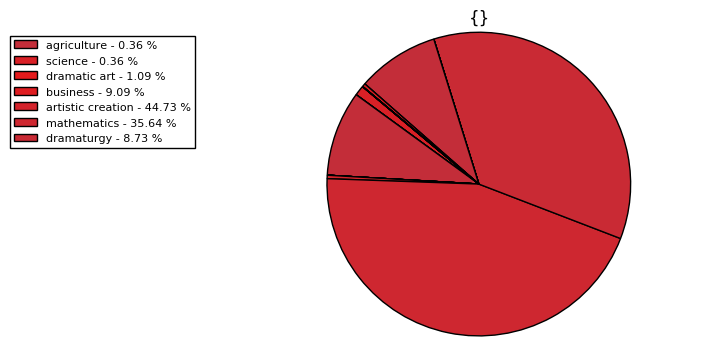

For Cluster ID 1
Visualization based on Category frequency: 


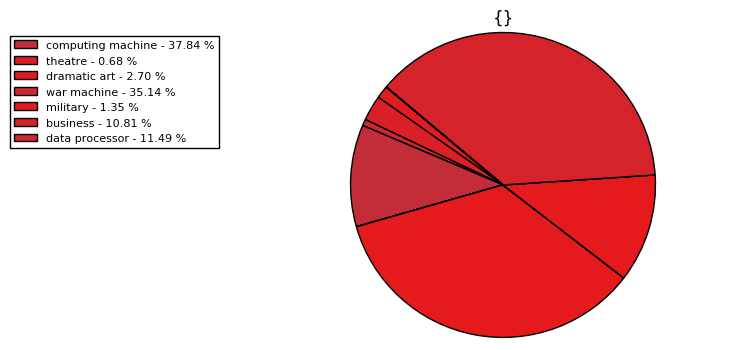

For Cluster ID 2
Visualization based on Category frequency: 


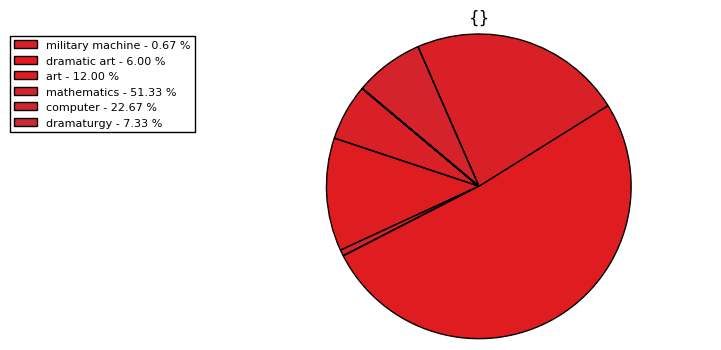

For Cluster ID 3
Visualization based on Category frequency: 


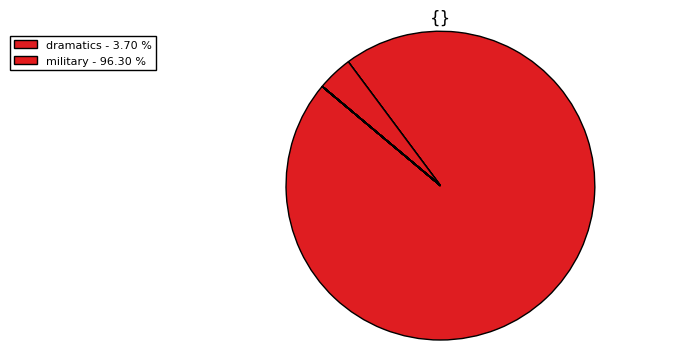

For Cluster ID 4
Visualization based on Category frequency: 


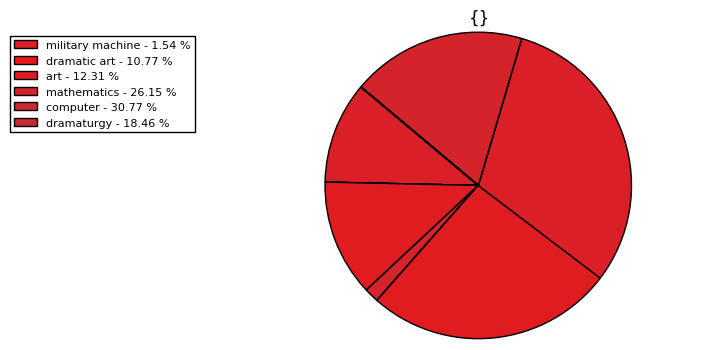

For month July
For Cluster ID 0
Visualization based on Category frequency: 


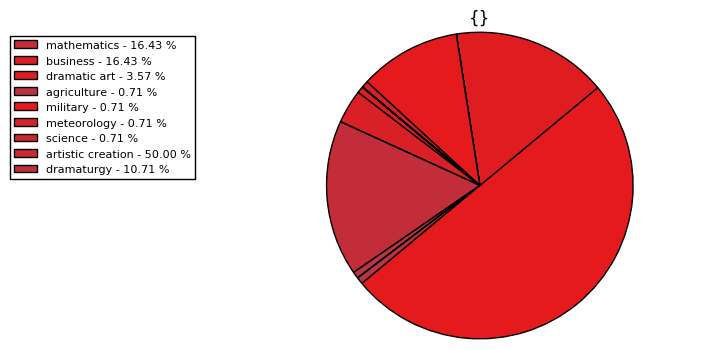

For Cluster ID 1
Visualization based on Category frequency: 


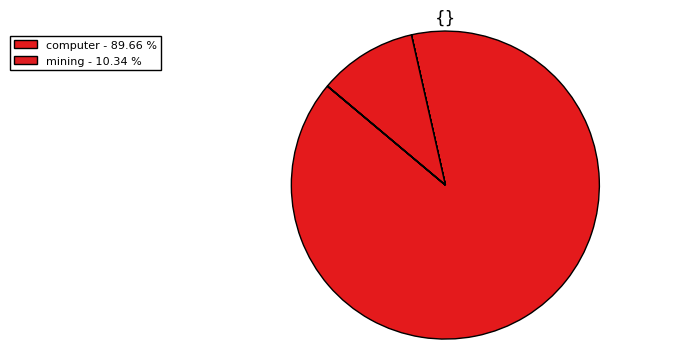

For Cluster ID 2
Visualization based on Category frequency: 


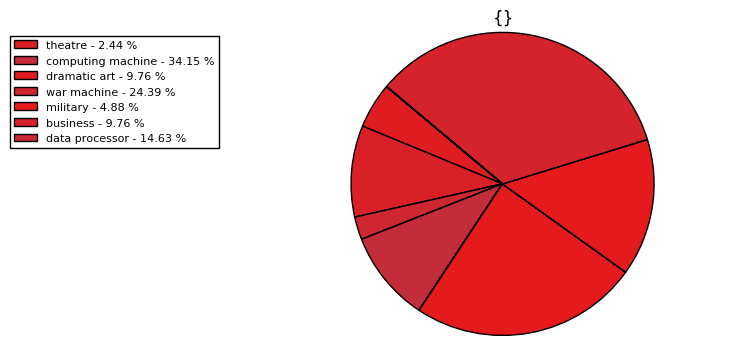

For Cluster ID 3
Visualization based on Category frequency: 


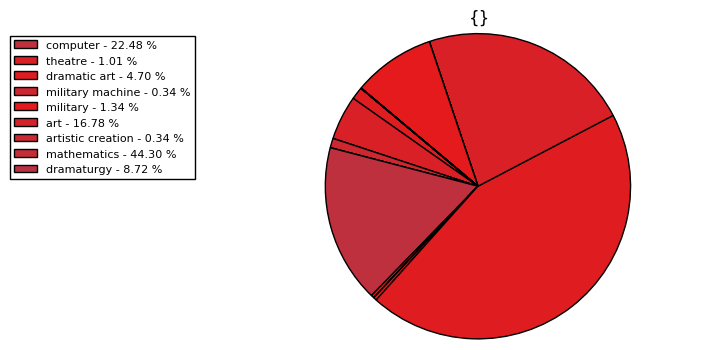

For Cluster ID 4
Visualization based on Category frequency: 


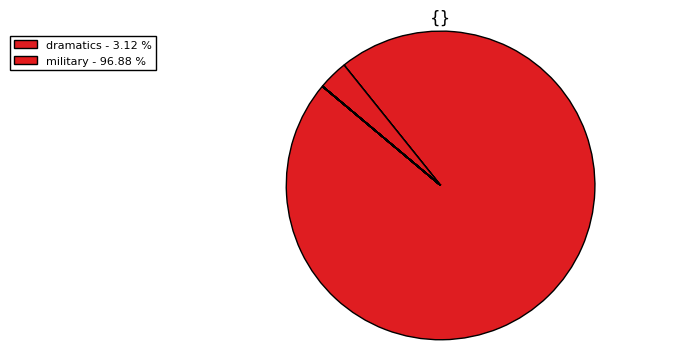

For month August
For Cluster ID 0
Visualization based on Category frequency: 


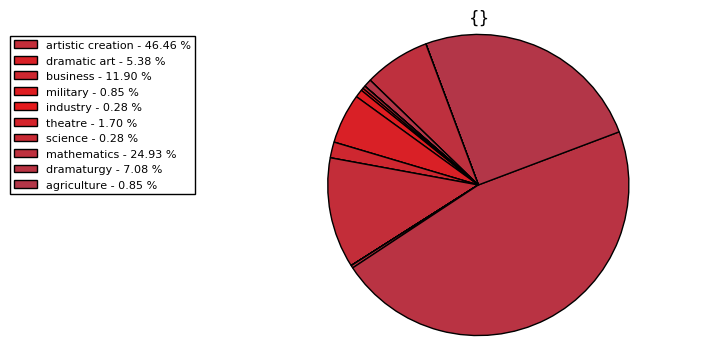

For Cluster ID 1
Visualization based on Category frequency: 


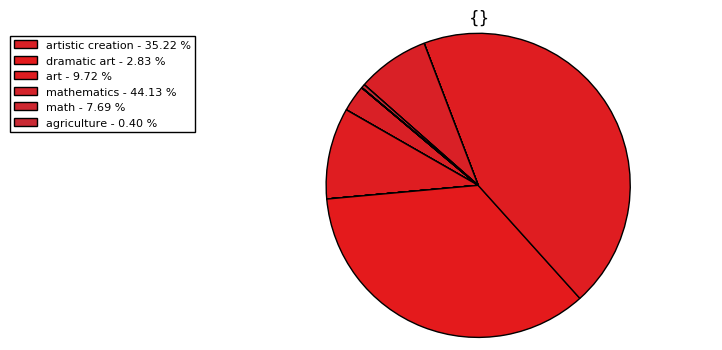

For Cluster ID 2
Visualization based on Category frequency: 


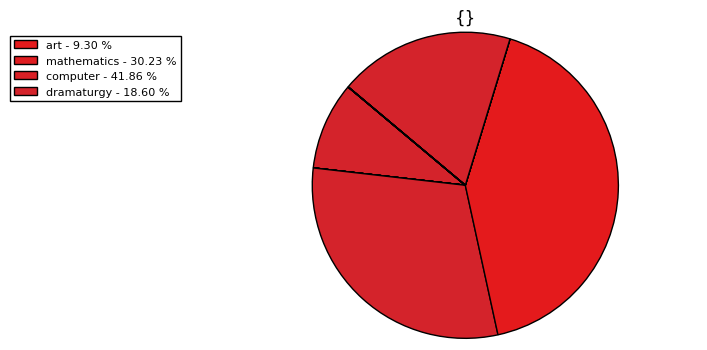

For Cluster ID 3
Visualization based on Category frequency: 


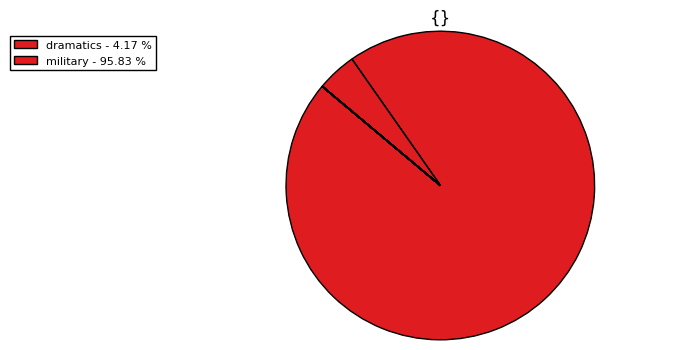

For Cluster ID 4
Visualization based on Category frequency: 


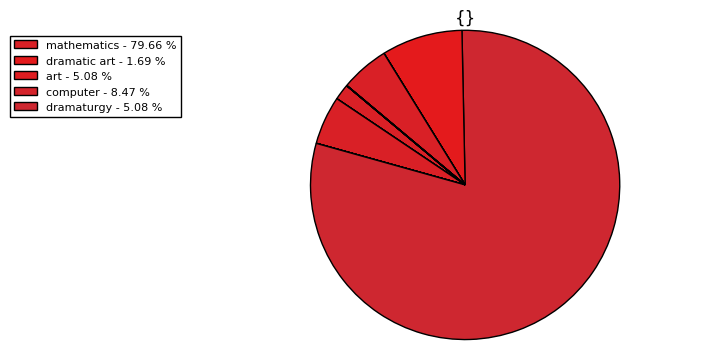

For month September
For Cluster ID 0
Visualization based on Category frequency: 


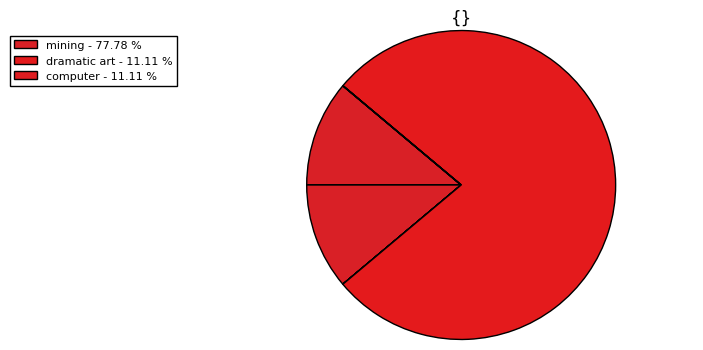

For Cluster ID 1
Visualization based on Category frequency: 


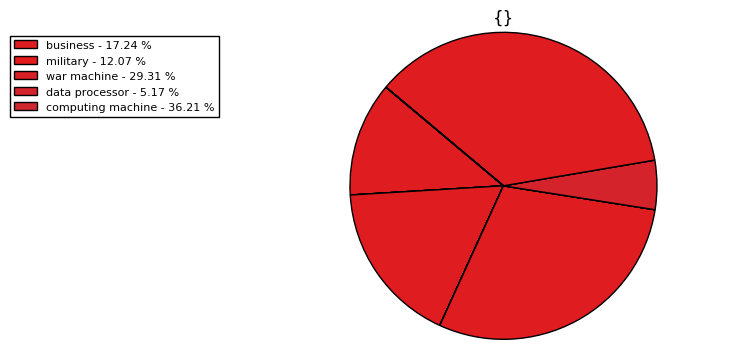

For Cluster ID 2
Visualization based on Category frequency: 


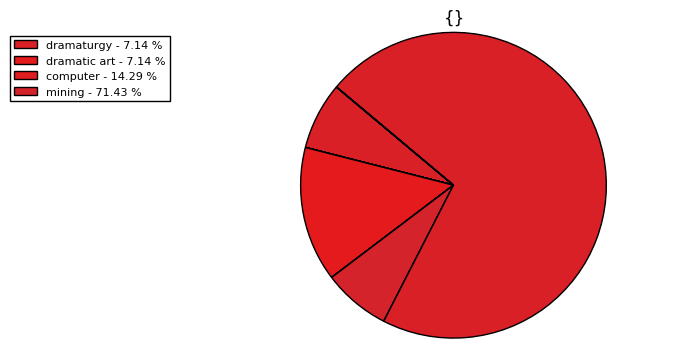

For Cluster ID 3
Visualization based on Category frequency: 


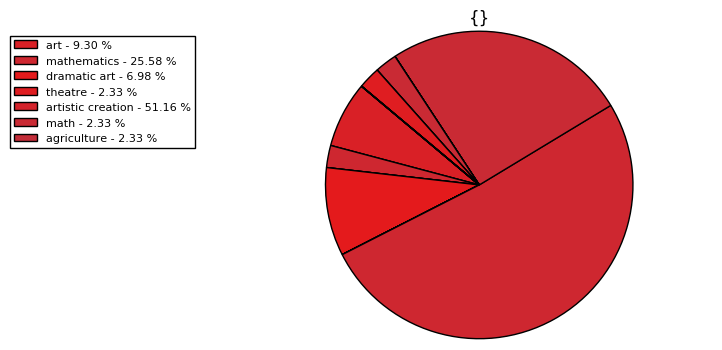

For Cluster ID 4
Visualization based on Category frequency: 


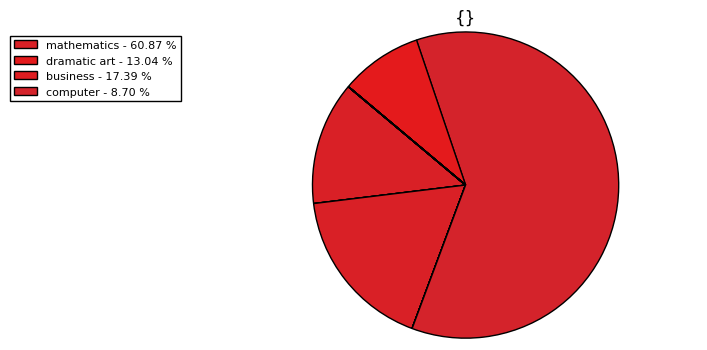

Done Visualising and saving pie charts...


In [47]:
#Creates a pie chart and saves it as a png file to be loaded later

fileNameTemplate = path+'\Plot{0:s}'
categoryy_list=categories.keys()
categoryy_list=list(categoryy_list)
for month in date_list:
    print("For month",month)
    for cluster_id in range(0,num_clusters):
        print("For Cluster ID",str(cluster_id))
        print('Visualization based on Category frequency: ', flush = True)
        y=np.array(list(topic_categories_freq[month][cluster_id].values()))
        percent = 100.*y/y.sum()
        indices=np.where(percent == 0)[0].tolist()
        porcent=np.delete(percent,indices)
        np.asarray(categoryy_list)
        category_list=np.delete(categoryy_list,indices).tolist()
        labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(category_list, porcent)]
        sizes = list(topic_categories_freq[month][cluster_id].values())
        cs=cm.Set1(np.arange(len(labels)))
        explode = (0.1, 0, 0, 0)  # explode 1st slice: Change this anyway you like
        patches,text=plt.pie(sizes, colors=cs, startangle=140)
        plt.title(words_dict[month][cluster_id])
        plt.axis('equal')
        sort_legend = True
        if sort_legend:
            patches, labels, dummy =  zip(*sorted(zip(patches, labels, sizes),
                                              key=lambda x: x[2],
                                              reverse=True))

        plt.legend(patches, labels, loc='left center', bbox_to_anchor=(-0.1, 1.),
               fontsize=8)
        plt.savefig(fileNameTemplate.format(str(month)+'-'+str(cluster_id)+'.png'), format='png', bbox_inches='tight')
        plt.show()
print('Done Visualising and saving pie charts...')

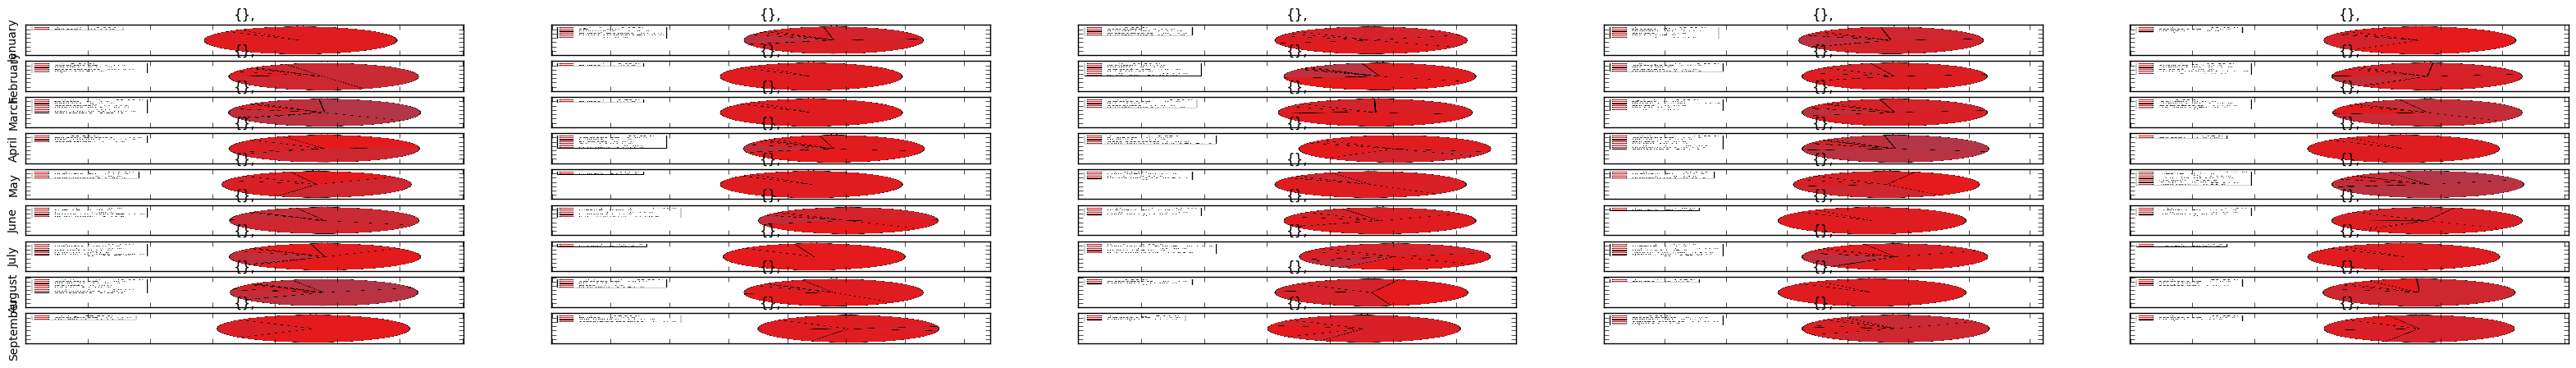

Done plotting for months...
Done plotting ...


In [48]:
#Loads back the saved png pie charts to be displayed over cluster axis

fig, axarr = plt.subplots(nrows=len(date_list),ncols= num_clusters, sharex='col', sharey='row',  figsize=(40,5))
c=0   
r=0
if len(date_list)==1:
    axarr[0].yaxis.set_label_position("left")
    axarr[0].set_ylabel(date_list[0])
    c=0
    for col in range(0,num_clusters):
        ttl=''
        for top in col:
            ttl=ttl+mydict[str(top)]+','
        axarr[c].set_title(ttl)
        img=fileNameTemplate.format(str(col))+'-'+date_list[0]+'.png'
        o=axarr[c].imshow(mpimg.imread(img),interpolation='nearest', aspect='auto')
        plt.setp(axarr[c].get_xticklabels(), visible=False)
        plt.setp(axarr[c].get_yticklabels(), visible=False)
        c+=1
    
#else use numpy multi-dimesnional array
else:
     r=0
     for row in date_list:
        c=0
        axarr[r,0].yaxis.set_label_position("left")
        axarr[r,0].set_ylabel(row)
        for col in range(0,num_clusters):  
            ttl=''
            ttl=ttl+str(words_dict[row][col])+','
            axarr[r,c].set_title(ttl)
            img=fileNameTemplate.format(str(row)+'-'+str(col))+'.png'
            o=axarr[r,c].imshow(mpimg.imread(img),interpolation='nearest',aspect='auto')
            plt.setp(axarr[r,c].get_xticklabels(), visible=False)
            plt.setp(axarr[r,c].get_yticklabels(), visible=False)
            c+=1
        r+=1
plt.show()
print("Done plotting for months...")
print("Done plotting ...")